# Land Cover Classification

## Part 1: Training Data 

<hr style="border:0.25px solid gray"> </hr>

## Introduction 

A Land Cover map can be used to map the various types of land cover (streams, built-up) and also the forest cover (evergreen forest, mixed forest and invasive plant species). There are three invasive plant species seen within Betampona Nature Reserve (BNR): Madagascar Cardamom, Molucca Raspberry and Strawberry Guava. 
BNR is located in northeastern Madagascar and was designated a strict Nature Reserve in 1927.

The table below lists the land cover classes along with the detailed descriptions

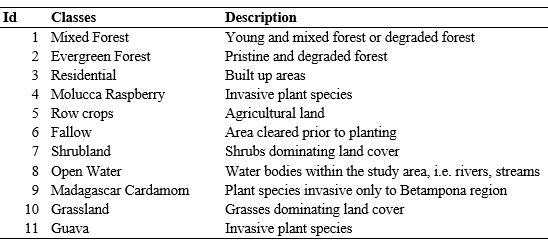

## 0. Data

Data included with this lab
* data_img.tif: 16 band WV-3 image .tif file
* Bet_LandCover_2020.tif: label image

### 0.1. Imagery Data

The imagery used for this lab is the WorldView-3 (WV-3) imagery collected on February 19th 2019. The imagery was radiometrically and atmospherically corrected.


### 0.2. Classification Methods

To create the land cover map, we will use pixel based classification methods 
1. Support Vector Machine (SVM)
2. Random Forest (RF)
3. Deep Neural Network (DNN)
4. Fully Convolutional Network (FCNN)              
      4.1 U-Net               

Support Vector Machine and Random Forest are typical machine learning models and are used for comparison. Deep Neural Network is a multilayer perceptron network, which is also used for comparison with deep learning models. 

An FCNN performs pixel-wise semantic segmentation. It performs pixel-wise classification, by creating semantic objects through a fully convolutional architecture. 

Thus, a FCNN would outperform other pixel based methods, and produce and automated, end-to-end land cover map. 

## 1. Creating Training Samples

Training data includes data for predictor variables 'X' and corresponding label 'Y'. 

All classification methods require numpy arrays as an input. The shape of the data depends for each classification method. 

    SVM, RF and DNN all require 2D arrays for X (n, 16), where n is the number of sample pixels and 16 is the number of predictor variables, i.e. spectral bands

    SVM and RF require a 1D array for Y (n, ). However, DNN requires a one-hot encoded form of Y, and therefor would be a 2D array (n, 11), where 11 corresponds to the number of classes. 

    FCNNs require an image patch as the input (n, h, w, 16), where h and w is the height and width respectively. For FCNN, a one-hot encoded label patch is needed (n, h, w, 11), since this architecture performs semantic segmentation of input image patch

See the below image of an label-image pair

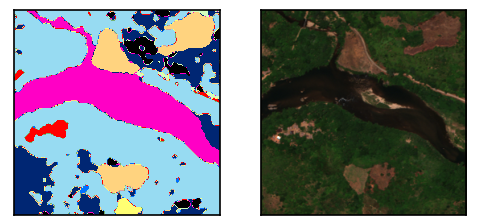

### 1.1. Importing Libraries

'rasterio' will be used to import the multispectral image and save image patches.

In [ ]:
!pip install rasterio

In [2]:
import matplotlib.pyplot as plt # used for visualization
import numpy as np 
import rasterio # to import multispectral data

### 1.2. Importing data

In [260]:
# importing the 16 band WV-3 imagery

src= rasterio.open(r'./data_img.tif') # change file path
data_img=src.read()
img_profile = src.profile
src.close()

In [261]:
# importing reference label image

src=rasterio.open(r'./Bet_LandCover_2020.tif') # change file path
label_img= src.read()
label_profile = src.profile
src.close()

In [5]:
print(data_img.shape, label_img.shape) # bands x rows x cols

(16, 8097, 8780) (1, 8097, 8780)


### 1.3. Define variables

To compare results of multiple classification models, they will need to be trained and tested on the same training and testing data. 

Therefore, we will extract the image patches for FCNN first and then use the pixels within those patches for the other pixel-based models. 

Image patches can be clipped by indexing the data_img array based on a row and column value. 

In the next code block, 'a_list' and 'c_list' are defined to be row and column 'start' values that can be used to extract image patches. These values are manually compiled. b and d are the end values, created by adding the patch size and values in a_list and c_list. Values within a_list and c_list are selected based on indexing. 

In [516]:
patch_size= 256 

# define lists of row and column location where the images and labels can be extracted from 
a_list=[6900, 5600, 5390, 5650, 5800, 4610, 3000, 7700, 5270, 4570, 5470,  655, 5200, 1100, 6330,  700, 3750, 941, 4100, 4300, 200, 1000, 5000, 600, 2000, 6900, 6900, 6900,  700, 5200, 1100,  655, 1100, 1100,  655,  655,  655,  655,  655, 655, 655,  655, 200, 100, 6900, 7000, 7000, 5500, 6000, 4000, 7000, 800, 3000, 3000, 6500,  800,  100, 3500, 3500, 6500, 6500, 6500,  200, 4000, 3000] #  values 
c_list=[4950, 3830, 2700, 1750, 2600, 5430, 4100, 1400, 2000, 1760, 3200, 8355, 4800, 1910, 7940, 4500, 7500, 923,  550, 6200, 200, 1000, 6000, 600, 2300, 3830, 2700, 1750, 7500, 1910, 4800, 4800, 4800, 5200, 4800, 1910, 7940, 4500, 7500, 930, 550, 6200, 700, 700, 2700, 2000,  200, 5500, 6000, 4000, 6000, 500, 2000, 7000,  200, 6000, 6500, 4500, 3200, 1500, 1200, 6500, 6500,  400, 4000]
     
i=1
a= a_list[i-1]
b= a + patch_size
c= c_list[i-1]
d= c + patch_size

### 1.4. Visualization

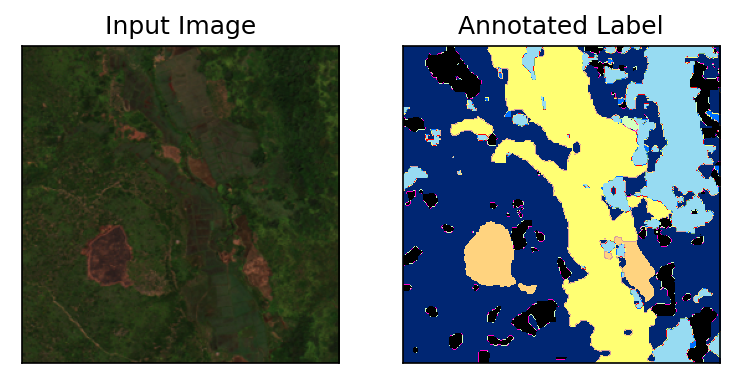

(array([0, 3, 4, 5, 6, 8, 9], dtype=uint8), array([ 8976,   239, 14680,  2545, 33326,   104,  5666]))


In [515]:
a= 1100
b= a + patch_size
c= 1910
d= c + patch_size

# visualizing image and label patch
fig, ax= plt.subplots(1,2, sharey= True,dpi=150)

# extracting true color composite (tcc)
red= data_img[4, a:b, c:d]
green= data_img[2, a:b, c:d]
blue = data_img[1, a:b, c:d]

tcc= np.dstack((red, green, blue))
tcc=tcc*2.55

ax[0].imshow(tcc)
ax[0].set_title("Input Image")

ax[1].imshow(label_img.reshape(8097,8780)[ a:b, c:d])
ax[1].set_title("Annotated Label")

for i in range(2):
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)

plt.show()
# return class ids and counts for each class id
print('Unique Class Ids',np.unique(label_img.reshape(8097,8780)[ a:b, c:d], return_counts=True)) 

### 1.5. Saving Image Patches

In [517]:
i=1       # specify number to index a_list and c_list; increase sequentially to save all patches
a=a_list[i-1]
b=a+patch_size
c=c_list[i-1]
d=c+patch_size
print(i, a, b, c, d)

14 1100 1356 1910 2166


In [518]:
img_patch= data_img[:, a:b, c:d]
lab_patch= label_img[:, a:b, c:d]

# update metadata for image
img_profile.update(
    dtype=img_patch.dtype,
    count=16,
    driver='GTiff',
    height= patch_size,
    width= patch_size)

# saving image patch using rasterio
with rasterio.open('./image_0{}.tif'.format(i), 'w', **img_profile) as wrt: # change file path
  wrt.write(img_patch.astype(rasterio.float32))

# update metadata for label
label_profile.update(
    dtype=lab_patch.dtype,
    count=1,
    height=patch_size,
    width=patch_size,
    compress='lzw')

# saving label patches using rasterio
with rasterio.open('./label_0{}.tif'.format(i), 'w', **label_profile) as wrt: # change file path
  wrt.write(lab_patch.astype(rasterio.uint8))

## 2. Importing as numpy arrays

In [ ]:
!pip install rasterio

In [2]:
import glob
import os
import numpy as np
import rasterio
import cv2
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

### 2.1. Functions


In [3]:
# function to import images from image_paths as numpy arrays
def image_processor(image_path, width=256, height=256,selected_bands=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]):

  # import image as np array from image_path
  src= rasterio.open(image_path)
  img= src.read()
  src.close()

  # moveaxis to be (height x width x n_channels)
  img= np.moveaxis(img, 0, 2)

  # return numpy array 
  return img.reshape(1, img.shape[0], img.shape[1], img.shape[2])

# creating label data of 11 dimensions aka one-hot encoded
def label_one_hot(label, n_classes=11): 

  # create an empty numpy array of shape (height x width x n_classes)
  zeros= np.zeros((label.shape[0], label.shape[1], n_classes))
  index= np.unique(label)  # unique index for each class

  for i in index:
    onehot_encoded= (label==i).astype(int) # if label == index (i), then replace True with 1 and False with 0
    zeros[:, :, int(i)]= onehot_encoded.reshape(256,256) # place one-hot encoded into zeros

  return zeros.reshape(1, zeros.shape[0], zeros.shape[1], n_classes)

# creates paths for every 'tif' file in any directory
def path_generator(base_path):
  image_paths = glob.glob(os.path.join(base_path, '**', '*.tif'), recursive=True)
  return image_paths

### 2.2. Defining variables

In [4]:
width=256
height=256
selected_bands=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
n_classes=11

### 2.3. Importing image and label data

Split Images and labels into training and testing data, and save within 'train/image' 'train/label' and 'test/image' 'test/label' folders

In [5]:
## create train images, train labels, test images and test label paths
 
train_image_paths= path_generator('./train/image') # change file paths
train_label_paths= path_generator('./train/label')

test_image_paths = path_generator('./test/image')
test_label_paths = path_generator('./test/label')

In [6]:
print(train_image_paths)
print(train_label_paths)
print(test_image_paths)
print(test_label_paths)

['/content/drive/MyDrive/Thesis-lab/train/image/image_002.tif', '/content/drive/MyDrive/Thesis-lab/train/image/image_004.tif', '/content/drive/MyDrive/Thesis-lab/train/image/image_005.tif', '/content/drive/MyDrive/Thesis-lab/train/image/image_006.tif', '/content/drive/MyDrive/Thesis-lab/train/image/image_007.tif', '/content/drive/MyDrive/Thesis-lab/train/image/image_009.tif', '/content/drive/MyDrive/Thesis-lab/train/image/image_010.tif', '/content/drive/MyDrive/Thesis-lab/train/image/image_011.tif', '/content/drive/MyDrive/Thesis-lab/train/image/image_012.tif', '/content/drive/MyDrive/Thesis-lab/train/image/image_013.tif', '/content/drive/MyDrive/Thesis-lab/train/image/image_014.tif']
['/content/drive/MyDrive/Thesis-lab/train/label/label_002.tif', '/content/drive/MyDrive/Thesis-lab/train/label/label_004.tif', '/content/drive/MyDrive/Thesis-lab/train/label/label_005.tif', '/content/drive/MyDrive/Thesis-lab/train/label/label_006.tif', '/content/drive/MyDrive/Thesis-lab/train/label/label_

#### 2.3.1. numpy creation

In [7]:
image_paths= train_image_paths
label_paths= train_label_paths

# import training images and training labels as numpy arrays
train_images= np.zeros((len(image_paths), width, height, len(selected_bands)))
train_labels= np.zeros((len(label_paths), width, height, 1))

for i in range(len(image_paths)):
  train_images[i, :, :, :]=image_processor(image_paths[i], width, height, selected_bands)
  train_labels[i, :, :, :]=image_processor(label_paths[i], width, height, selected_bands=[1])


In [8]:
image_paths= test_image_paths
label_paths= test_label_paths

# import testing images and testing labels as numpy arrays
test_images= np.zeros((len(image_paths), width, height, len(selected_bands)))
test_labels= np.zeros((len(label_paths), width, height, 1))

for i in range(len(image_paths)):
  test_images[i, :, :, :]=image_processor(image_paths[i], width, height, selected_bands)
  test_labels[i, :, :, :]=image_processor(label_paths[i], width, height, selected_bands=[1])


In [9]:
print(train_images.shape, train_labels.shape) 
print(test_images.shape, test_labels.shape) 

(11, 256, 256, 16) (11, 256, 256, 1)
(3, 256, 256, 16) (3, 256, 256, 1)


In [28]:
## one hot encoding for image patches

train_labels_onehot=np.zeros((len(train_label_paths), width, height, n_classes))
test_labels_onehot= np.zeros((len(test_label_paths), width, height, n_classes))

for i in range(len(train_label_paths)):
  train_labels_onehot[i, :, :, :]=label_one_hot(train_labels[i], n_classes)

for i in range(len(test_label_paths)):
  test_labels_onehot[i, :, :, :]=label_one_hot(test_labels[i],  n_classes)

In [29]:
print(train_images.shape, train_labels_onehot.shape) 
print(test_images.shape, test_labels_onehot.shape) 

(11, 256, 256, 16) (11, 256, 256, 11)
(3, 256, 256, 16) (3, 256, 256, 11)


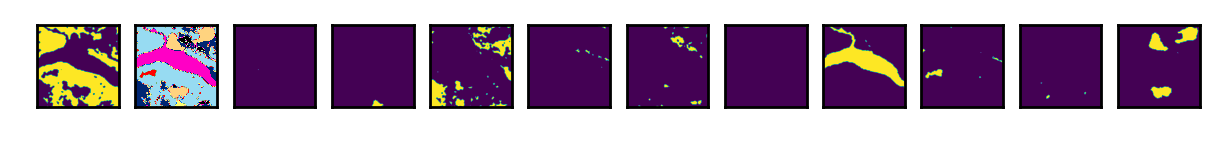

In [35]:
# visualizing each band within one-hot encoded labels 

fig, ax= plt.subplots(1,12, sharey= True,dpi=250)
zeros=test_labels_onehot[0]

ax[0].imshow(test_labels[0,:, :, 0])
ax[1].imshow(zeros[:,:, 0])
ax[2].imshow(zeros[:,:, 1])
ax[3].imshow(zeros[:,:, 2])
ax[4].imshow(zeros[:,:, 3])
ax[5].imshow(zeros[:,:, 4])
ax[6].imshow(zeros[:,:, 5])
ax[7].imshow(zeros[:,:, 6])
ax[8].imshow(zeros[:,:, 7])
ax[9].imshow(zeros[:,:, 8])
ax[10].imshow(zeros[:,:,9])
ax[11].imshow(zeros[:,:, 10])

for i in range(12):
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)

plt.show()

In [536]:
# checking number of pixels for each class within training and testing data
print(np.unique(train_labels,return_counts=True))
print(np.unique(test_labels, return_counts=True))

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]), array([186191, 155006,  15619,  41635,  46807,  10652, 155915,   4942,
        37513,  33876,  32740]))
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]), array([59936, 39168, 12116,   494,  1519,  9524, 21113, 26879, 14861,
        2746,  8252]))


In [ ]:
# check number of pixels for each class for each image and label patch 
for i in range(len(labels)):
  print(i+1, np.unique(labels[i], return_counts=True))

In [10]:
# numpy arrays for pixel level model trainig and testing (RF, SVM)

x_train= train_images.reshape(-1, 16) 
x_test = test_images.reshape(-1, 16)
y_train= train_labels.reshape(-1)     
y_test = test_labels.reshape(-1)     

In [11]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(720896, 16) (196608, 16) (720896,) (196608,)


In [12]:
# one hot encoding for pixel level model training and testing (DNN)

onehot_train = OneHotEncoder(sparse=False)
onehot_test= OneHotEncoder(sparse=False)

y_train= y_train.reshape(-1, 1)
y_test = y_test.reshape(-1,1)

y_train_onehot= onehot_train.fit_transform(y_train)
y_test_onehot= onehot_test.fit_transform(y_test)

print(x_train.shape)
print(x_test.shape)
print(y_train_onehot.shape)
print(y_test_onehot.shape)

(720896, 16)
(196608, 16)
(720896, 11)
(196608, 11)


### 2.4. Save arrays

Create folders prior to savingt the numpy arrays

In [24]:
# save patch level numpy arrays

np.save(r'./patch-level/X_train.npy', train_images) # change file paths
np.save(r'./patch-level/X_test.npy', test_images)
np.save(r'./patch-level/y_train.npy', train_labels)
np.save(r'./patch-level/y_test.npy', test_labels)

In [38]:
# save patch level (onehot) numpy arrays

np.save(r'./patch-one-hot/X_train.npy', train_images) # change file paths
np.save(r'./patch-one-hot/X_test.npy', test_images)
np.save(r'./patch-one-hot/y_train.npy', train_labels_onehot)
np.save(r'./patch-one-hot/y_test.npy', test_labels_onehot)

In [39]:
# save pixel level numpy arrays

np.save(r'./pixel-level/X_train.npy', x_train) # change file paths
np.save(r'./pixel-level/X_test.npy', x_test)
np.save(r'./pixel-level/y_train.npy', y_train)
np.save(r'./pixel-level/y_test.npy', y_test)

In [13]:
# save pixel level (onehot) numpy arrays

np.save(r'./pixel-one-hot/X_train.npy', x_train) # change file paths
np.save(r'./pixel-one-hot/X_test.npy', x_test)
np.save(r'./pixel-one-hot/y_train.npy', y_train_onehot)
np.save(r'./pixel-one-hot/y_test.npy', y_test_onehot)